In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
from tqdm.notebook import tqdm
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

import torchvision
from torchvision.models import alexnet
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

In [2]:
device = 'mps' if torch.backends.mps.is_available else 'cpu'
device

'mps'

In [3]:
df_train = pd.read_csv('../data/fashion-mnist_train.csv')
df_test = pd.read_csv('../data/fashion-mnist_test.csv')

#### EDA

In [4]:
print(df_train['label'].unique())
unique_count = df_train['label'].nunique()
print("Количество уникальных значений:", unique_count)

[2 9 6 0 3 4 5 8 7 1]
Количество уникальных значений: 10


In [5]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_train = X_train.values.reshape(-1, 28, 28, 1)

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']
X_test = X_test.values.reshape(-1, 28, 28, 1)

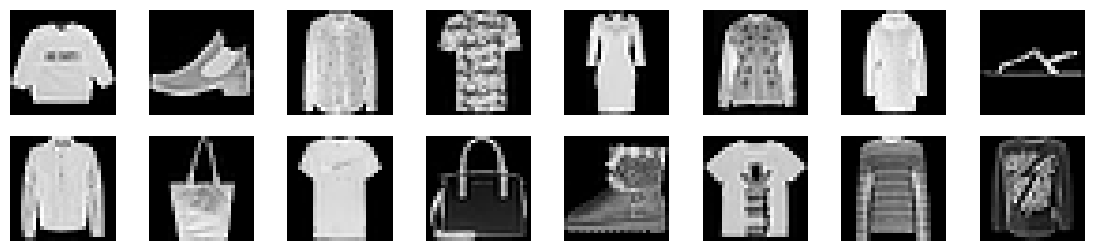

In [6]:
fig, ax = plt.subplots(ncols=8, nrows=2, figsize=(14, 3))
n = 0
for i in range(2):
    for j in range(8):
        ax[i][j].imshow(X_train[n], cmap='gray')
        ax[i][j].axis(False)
        n += 1
plt.show()

In [13]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

X_train_tesor = torch.tensor(data=X_train, dtype=torch.float32)
y_train_tesor = torch.tensor(data=y_train, dtype=torch.long)

X_test_tesor = torch.tensor(data=X_test, dtype=torch.float32)
y_test_tesor = torch.tensor(data=y_test, dtype=torch.long)

transform_aug = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-25, 25)),
])

X_train_tesor /= 255.0
X_test_tesor /= 255.0

augm_X_train = []
for image in X_train_tesor:
    aug_image = transform_aug(image)
    augm_X_train.append(aug_image)

augm_X_train = torch.stack(augm_X_train)
X_train_combined = torch.cat((X_train_tesor, augm_X_train), dim=0)
y_train_combined = torch.cat((y_train_tesor, y_train_tesor), dim=0)


dataset_train = TensorDataset(X_train_combined, y_train_combined)
# dataset_train = TensorDataset(X_train_tesor, y_train_tesor)
dataset_test = TensorDataset(X_test_tesor, y_test_tesor)

batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, shuffle=False)

#### Init Model

In [17]:
# class FashionMNISTNet(nn.Module):
#     def __init__(self):
#         super(FashionMNISTNet, self).__init__()

#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         # self.norm1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         # self.norm2 = nn.BatchNorm2d(64)

#         self.fc1 = nn.Linear(64 * 7 * 7, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# model = FashionMNISTNet()
# model.to(device)

FashionMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [19]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        self.conv_1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc_1 = nn.Linear(64*3*3, 128)
        self.fc_1 = nn.Linear(64*7*7, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = F.relu(self.conv_3(x))
        # x = self.pool(x) 
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        # pass
        return x

model = VGG8()
model.to(device)

VGG8(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=3136, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__*(
#             self.conv_1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
#             self.conv_2 = nn.Conv2d(6, 15, kernel_size=5)
#             self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            
#             self.fc_1 = nn.Linear(400, 120)
#             self.fc_2 = nn.Linear(120, 84)
#             self.fc_3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = F.relu(self.conv_1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv_2(x))
#         x = self.pool(x)
#         x = F.relu(self.fc_1(x))
#         x = F.relu(self.fc_2(x))
#         x = self.fc_3(x)
#         return x

# model = LeNet()
# model.to(device)

#### Train

In [15]:
def fit(model, loss_func, opt, train_loader, test_loader, epochs, scheduler):
    train_loss_hist = []
    test_loss_hist = []
    accuracy_hist = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        for xb, yb in tqdm(train_loader, desc=f'train {epoch+1} epoch'):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            avg_loss += loss.item()
        train_loss_hist.append(avg_loss / len(train_loader))
        scheduler.step()

        with torch.no_grad():
            model.eval()
            y_pred = []
            y_true = []
            avg_loss = 0
            for x, y in tqdm(test_loader, desc=f'test {epoch+1} epoch'):
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_func(output, y)
                avg_loss += loss.item()
                logit = torch.softmax(output, dim=1)
                _, pred = torch.max(logit, dim=1)
                y_pred.append(pred.item())
                y_true.append(y.item())
            test_loss_hist.append(avg_loss / len(test_loader))
            accuracy_hist.append(accuracy_score(y_true, y_pred))

        train_loss = round(train_loss_hist[-1], 5)
        test_loss = round(test_loss_hist[-1], 5)
        accuracy = round(accuracy_hist[-1], 5)
        lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch {epoch+1}'st: train_loss = {train_loss}, test_loss = {test_loss}, accuracy = {accuracy}, lr = {lr}")

    return train_loss_hist, test_loss_hist, accuracy_hist

In [20]:
epochs = 15
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())
opt = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[10], gamma=0.3)
# scheduler = lr_scheduler.MultiStepLR(opt, milestones=[15, 25, 32], gamma=0.5)

hist = fit(model, loss_func, opt, train_loader, test_loader, epochs, scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

train 1 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 1 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1'st: train_loss = 0.57406, test_loss = 0.34799, accuracy = 0.8682, lr = 0.001


train 2 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 2 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 2'st: train_loss = 0.37953, test_loss = 0.29115, accuracy = 0.8883, lr = 0.001


train 3 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 3 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 3'st: train_loss = 0.32061, test_loss = 0.27469, accuracy = 0.9011, lr = 0.001


train 4 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 4 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 4'st: train_loss = 0.28189, test_loss = 0.24838, accuracy = 0.9092, lr = 0.001


train 5 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 5 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 5'st: train_loss = 0.25192, test_loss = 0.24546, accuracy = 0.9095, lr = 0.001


train 6 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 6 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 6'st: train_loss = 0.22739, test_loss = 0.24896, accuracy = 0.9085, lr = 0.001


train 7 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 7 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 7'st: train_loss = 0.20768, test_loss = 0.23719, accuracy = 0.9157, lr = 0.001


train 8 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 8 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 8'st: train_loss = 0.1883, test_loss = 0.26758, accuracy = 0.9142, lr = 0.001


train 9 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 9 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 9'st: train_loss = 0.17107, test_loss = 0.27019, accuracy = 0.913, lr = 0.001


train 10 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 10 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 10'st: train_loss = 0.15494, test_loss = 0.29257, accuracy = 0.9112, lr = 0.0003


train 11 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 11 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 11'st: train_loss = 0.09729, test_loss = 0.29825, accuracy = 0.9181, lr = 0.0003


train 12 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 12 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 12'st: train_loss = 0.07795, test_loss = 0.32208, accuracy = 0.9185, lr = 0.0003


train 13 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 13 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 13'st: train_loss = 0.06603, test_loss = 0.34195, accuracy = 0.9172, lr = 0.0003


train 14 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 14 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 14'st: train_loss = 0.05632, test_loss = 0.38056, accuracy = 0.9161, lr = 0.0003


train 15 epoch:   0%|          | 0/3750 [00:00<?, ?it/s]

test 15 epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 15'st: train_loss = 0.04811, test_loss = 0.41712, accuracy = 0.9171, lr = 0.0003


#### Plots

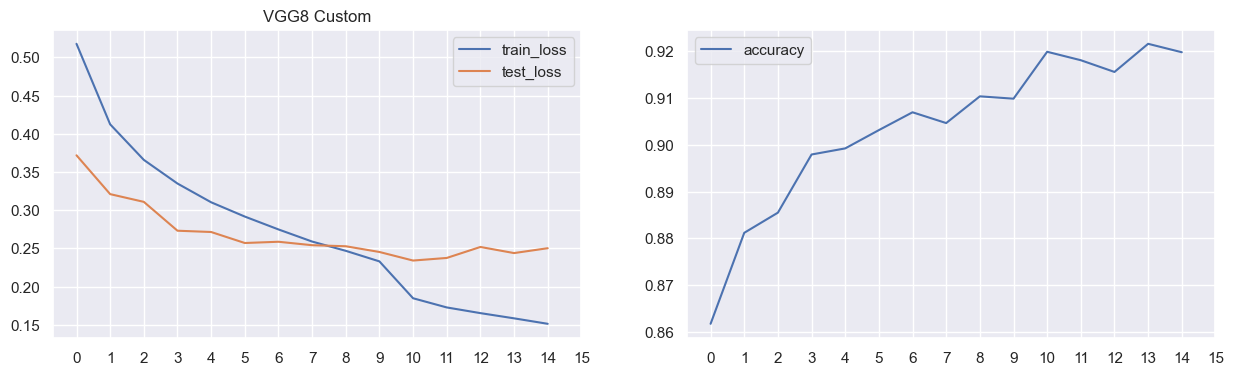

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
x = range(epochs)
sns.lineplot(x=x, y=hist[0], label='train_loss', ax=ax[0])
sns.lineplot(x=x, y=hist[1], label='test_loss', ax=ax[0])

sns.lineplot(x=x, y=hist[2], label='accuracy', ax=ax[1])

ax[0].set_title('VGG8 Custom')
ax[0].set_xticks(range(epochs+1))
ax[1].set_xticks(range(epochs+1))
plt.legend()
plt.show()

#### Eval

Epoch 35'st: train_loss = 0.00034, test_loss = 0.64219, accuracy = 0.9298, lr = 0.000125
\\\
Epoch 10'st: train_loss = 0.04837, test_loss = 0.27794, accuracy = 0.9255, lr = 0.0005
\\\
Epoch 15'st: train_loss = 0.22505, test_loss = 0.24879, accuracy = 0.9086, lr = 0.0005

In [28]:
def predict(model, test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for x, y in tqdm(test_loader):
            x, y = x.to(device), y.to(device)
            output = model(x)
            logit = torch.softmax(output, dim=1)
            _, pred = torch.max(logit, dim=1)
            y_true.append(y.item())
            y_pred.append(pred.item())
    return y_true, y_pred

In [30]:
y_true, y_pred = predict(model, test_loader)
print(f'accuracy = {accuracy_score(y_true, y_pred)}')

accuracy = 0.9197


In [35]:
df_ans = pd.DataFrame({
    'Id': range(0, 10_000),
    'Category': y_pred
})
df_ans.to_csv('../ans/ans_MNIST.csv', index=False)

In [32]:
df_ans

,Id,Category
0,0,0
1,1,1
2,2,2
3,3,2
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8


In [123]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'models/f_mnist.pth')